# Validity prediction

## Description / Goal

Goal: Create data model to predict properties (e.g., execution time, validity metric) of a simulation thanks to features regarding that simulation. The end goal is to define the approximation factor tu use for that simulation to match a defined execution budget (e.g., execution time).



## Import libraries

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
import os
import pandas as pd
import random
random.seed(42)
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier

## Functions to load 

In [71]:
def add_validity_feature_from_validation_metric(df_data, validity_threshold):
    df_data["Validity"] = np.where(df_data["Validation Metric"] > validity_threshold, 0, 1)
    return df_data

In [72]:
def retrieve_list_cases_and_split_data_BVE(data_complete, sites_completes, ratio_train):
    #Computing the number of sites that are used for the training
    training_nb_cases = round(len(sites_completes) * ratio_train)

    # Selecting the sites for the training and testing sets randomly 
    training_cases = random.sample(sites_completes.tolist(), training_nb_cases)
    testing_cases = [x for x in sites_completes.tolist() if x not in training_cases]
    
    # Retrieving the dataset for the training phase
    data_train = pd.DataFrame(columns=data_complete.columns)
    for cas in training_cases:
        train = data_complete.loc[(data_complete['SiteNumber'] == cas)]
        data_train = pd.concat([data_train, train], sort=False)
    # Retrieving the dataset for the testing phase
    data_test = pd.DataFrame(columns=data_complete.columns)
    for case in testing_cases:
        test = data_complete.loc[(data_complete['SiteNumber'] == case)]
        data_test = pd.concat([data_test, test], sort=False)

    return data_train, data_test, training_cases, testing_cases

In [73]:
def extract_features_and_outputs_datasets_BVE(data_train, data_test, features):
    # load names of all the features contained in the dataset to extract the data we want from
    global all_features
    
    y_train = data_train.filter(["SiteNumber", "Validity"], axis=1)
    X_train = data_train.drop(["Chronicle", "Validation Metric", "Accuracy", "Time", "Validity"], axis=1)
    del y_train["SiteNumber"]
    del X_train["SiteNumber"]
    
    y_test = data_test.filter(["SiteNumber", "Validity"], axis=1)
    X_test = data_test.drop(["Chronicle", "Validation Metric", "Accuracy", "Time", "Validity"], axis=1)
    del y_test["SiteNumber"]
    del X_test["SiteNumber"]
    
    
    features_to_remove = [feature for feature in all_features if feature not in features]
    for feature in features_to_remove:
        del X_train[str(feature)]
        del X_test[str(feature)]

    return X_train, y_train, X_test, y_test 

In [74]:
def train_forest(X_train, y_train):
    forest = RandomForestRegressor(
        n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1, oob_score = True, bootstrap = True
    )
    forest.fit(X_train, y_train.values.ravel())

    return forest

In [75]:
from sklearn import metrics

def compute_score(y_test, y_test_pred):
    acc_score = metrics.accuracy_score(y_test.values.ravel().astype(int), y_test_pred)
    return acc_score

In [76]:
def update_and_store_data_with_validity_pred(path, data_test, y_test, y_test_pred, testing_cases, one_case=False):
    suffixe = "_".join(map(str,list(map(int, sorted(testing_cases)))))
    # If we want the testing dataset to correspond to one unique site instead of a ratio (e.g., 20%)
    if one_case:
        suffixe += "_OneCase"
    data_test = data_test.assign(Validitytest=y_test.values.ravel())
    data_test = data_test.assign(ValidityPred=y_test_pred)
    
    data_test.to_csv(os.path.join(path,"data/Output_Data/Data_Test_With_Validity_pred_Rates_" + str(nb_rates) + "_Features_" + str('_'.join(features)) + "_" + str(scale)  + "_" + str(suffixe) + ".csv"), index=False, sep=";")
    return data_test

# Parameters

In [77]:
#path = "/Users/june/Dev/LAPrediction/"
path = os.path.abspath(os.path.join(os.path.abspath(""), os.pardir))
print(path)
nb_rates = 30
chronicle = 0
#features = "Geomorph_CVHV_Saturation_Cells"
scale = "BVE"
ratio_train = 0.8
validity_threshold = 0.1
k=3

# Different sets of features 
set_geomorph = ["Slope", "Elevation", "LC", "CW", "Area"]
set_CVHV = ["Coastal Vulnerability", "Hydrological Vulnerability"]
set_saturation= ["Satured Zone Area", "Vulnerability Sum", "Vulnerability Rate"]
set_cells = ["Number of Cells"]
all_features = set_geomorph + set_CVHV + set_saturation + set_cells

# We select the type of features we want to use for training our model
features = set_geomorph

/Users/june/Dev/LAPrediction


# Pipeline

In [88]:

def pipeline_pred_validity(path, nb_rates, features, scale, ratio_train):
    df_data = pd.read_csv(os.path.join(path, "data/", "Input_Data_Time_ValidMetric_Features_Rates_" + str(nb_rates) + "_Features_" + "Geomorph_CVHV_Saturation_Cells" + "_" + str(scale) + "_Comparable.csv"), sep=";")
    #data_complete = extract_complete_data_for_BVE(df_data)
    sites_completes = df_data.SiteNumber.unique()
    df_data = add_validity_feature_from_validation_metric(df_data, validity_threshold)
    data_train, data_test, training_cases, testing_cases = retrieve_list_cases_and_split_data_BVE(df_data, sites_completes, ratio_train)
    X_train, y_train, X_test, y_test = extract_features_and_outputs_datasets_BVE(data_train, data_test, features)
    global k
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train.values.ravel().astype(int))
    y_test_pred = classifier.predict(X_test)
    acc_score = compute_score(y_test, y_test_pred)
    print("Accuracy Score:", acc_score)
    data_test = update_and_store_data_with_validity_pred(path, data_test, y_test, y_test_pred, testing_cases, one_case=False)
    return acc_score

    

In [89]:
scores_acc = []
for i in range(30):
    acc_score = pipeline_pred_validity(path, nb_rates, features, scale, ratio_train)
    scores_acc.append(acc_score)

Accuracy Score: 0.92
Accuracy Score: 0.9133333333333333
Accuracy Score: 0.86
Accuracy Score: 0.8666666666666667
Accuracy Score: 0.9133333333333333
Accuracy Score: 0.94
Accuracy Score: 0.8266666666666667
Accuracy Score: 0.92
Accuracy Score: 0.8866666666666667
Accuracy Score: 0.84
Accuracy Score: 0.78
Accuracy Score: 0.9066666666666666
Accuracy Score: 0.8266666666666667
Accuracy Score: 0.8733333333333333
Accuracy Score: 0.9133333333333333
Accuracy Score: 0.8733333333333333
Accuracy Score: 0.9
Accuracy Score: 0.9066666666666666
Accuracy Score: 0.8866666666666667
Accuracy Score: 0.92
Accuracy Score: 0.9
Accuracy Score: 0.8866666666666667
Accuracy Score: 0.8933333333333333
Accuracy Score: 0.9
Accuracy Score: 0.94
Accuracy Score: 0.9
Accuracy Score: 0.9133333333333333
Accuracy Score: 0.8733333333333333
Accuracy Score: 0.96
Accuracy Score: 0.7066666666666667


In [90]:
import statistics
print(scores_acc)
statistics.mean(scores_acc)

[0.92, 0.9133333333333333, 0.86, 0.8666666666666667, 0.9133333333333333, 0.94, 0.8266666666666667, 0.92, 0.8866666666666667, 0.84, 0.78, 0.9066666666666666, 0.8266666666666667, 0.8733333333333333, 0.9133333333333333, 0.8733333333333333, 0.9, 0.9066666666666666, 0.8866666666666667, 0.92, 0.9, 0.8866666666666667, 0.8933333333333333, 0.9, 0.94, 0.9, 0.9133333333333333, 0.8733333333333333, 0.96, 0.7066666666666667]


0.8848888888888888

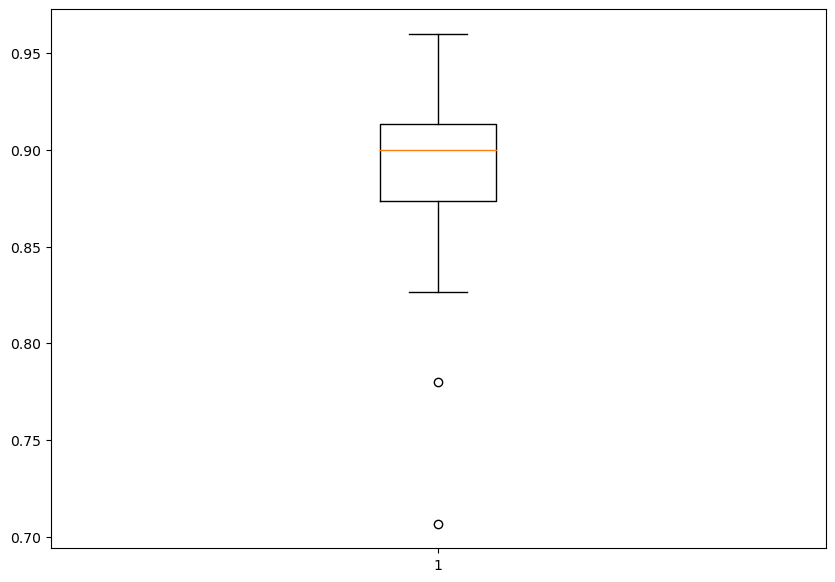

In [93]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
#Creating dataset
#np.random.seed(10)
#data = np.random.normal(100, 20, 200)
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(scores_acc)
 
# show plot
plt.show()

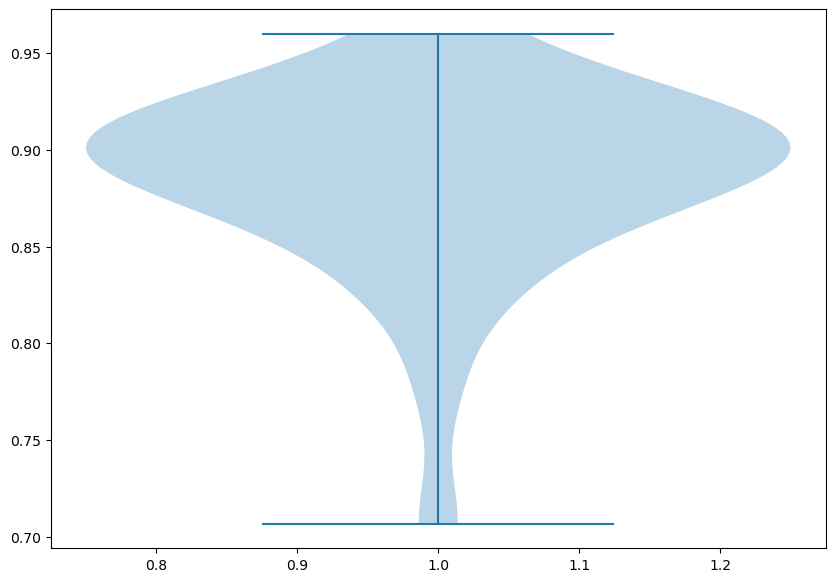

In [94]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.violinplot(scores_acc)
 
# show plot
plt.show()

In [27]:
#df_data.to_csv(os.path.join(path, "data/", "Input_Data_Time_ValidMetric_Features_Rates_" + str(nb_rates) + "_Features_" + "Geomorph_CVHV_Saturation_Cells_Validity" + "_" + str(scale) + "_Comparable.csv"), sep=";", index=False)